
✓ Price data downloaded.

=== Adjusted Close Prices ===


Ticker,AAPL,MSFT,NVDA,AMZN,GOOGL
Date,,,,,
2020-01-02,72.468254,152.791122,5.971409,94.900497,67.965225
2020-01-03,71.763725,150.888641,5.875832,93.748497,67.609695
2020-01-06,72.335548,151.278610,5.900473,95.143997,69.411766
2020-01-07,71.995361,149.899277,5.971908,95.343002,69.277687
2020-01-08,73.153503,152.286942,5.983109,94.598503,69.770782


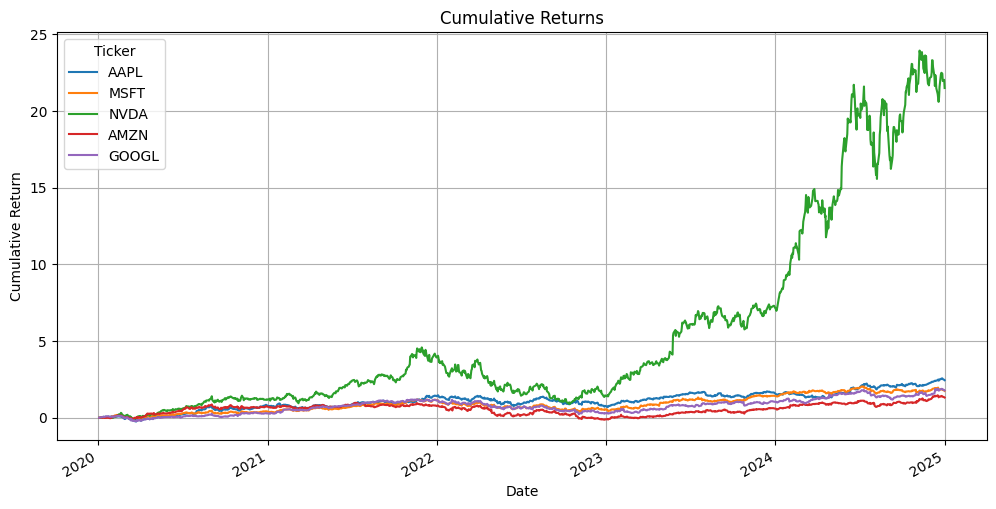

=== Monthly Returns ===


Ticker,AAPL,MSFT,NVDA,AMZN,GOOGL
Date,,,,,
2020-02-29,-0.114701,-0.045688,0.142967,-0.062214,-0.065279
2020-03-31,-0.069761,-0.026541,-0.023957,0.035021,-0.132388
2020-04-30,0.155374,0.136326,0.108801,0.268900,0.159000
2020-05-31,0.085094,0.025391,0.214657,-0.012785,0.064469
2020-06-30,0.147386,0.110559,0.070597,0.129567,-0.010792


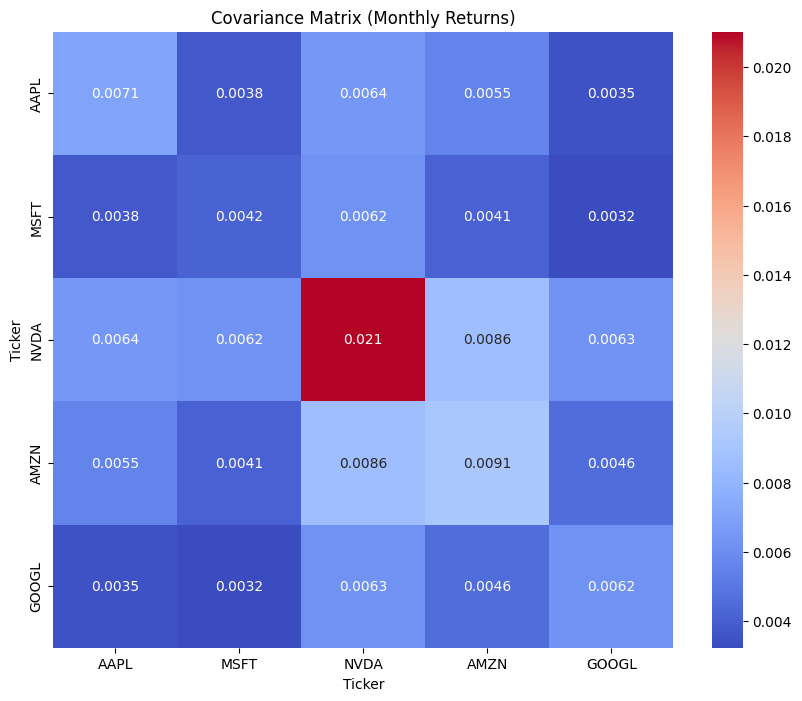

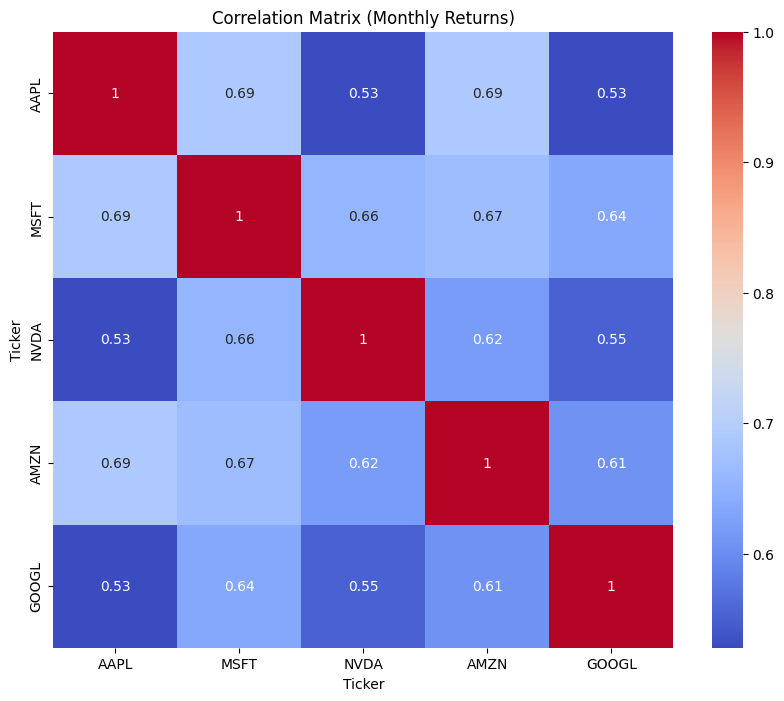

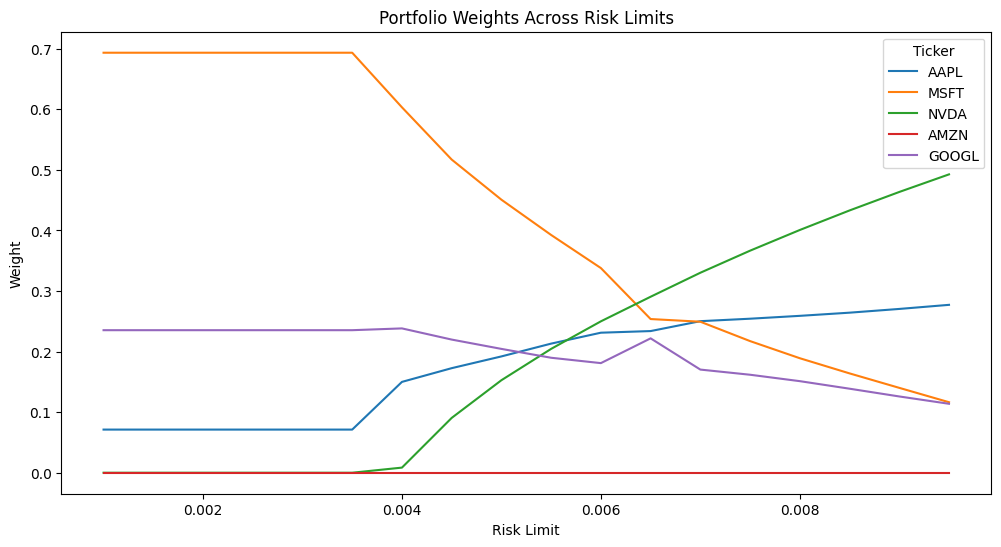

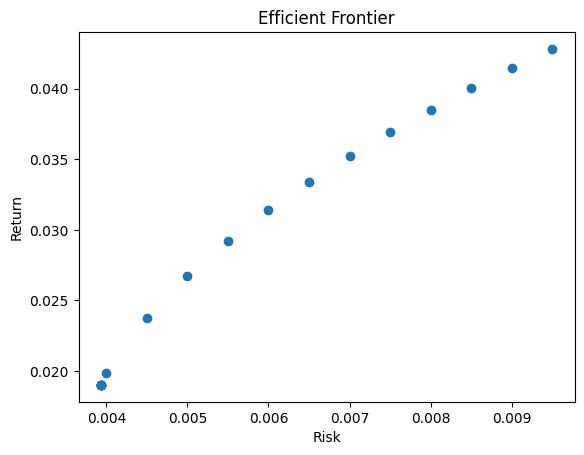

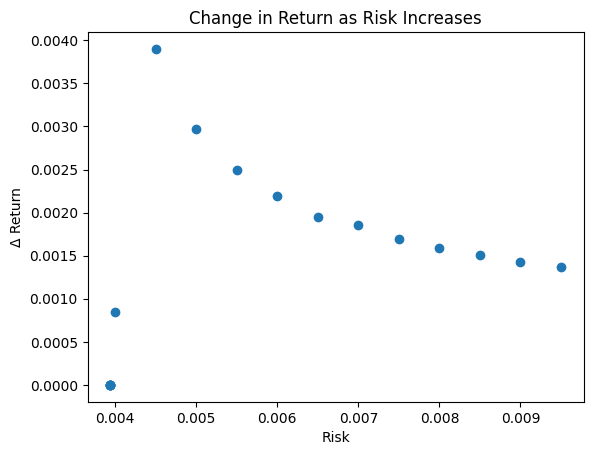

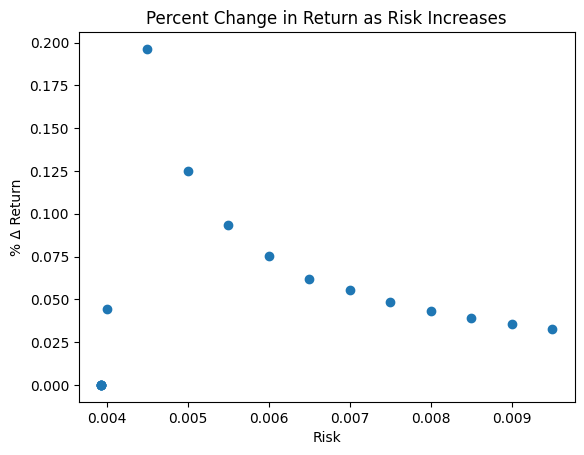


=== First 5 Allocation Rows ===


Ticker,AAPL,MSFT,NVDA,AMZN,GOOGL
0.0010,0.071226,0.693445,0.000000e+00,0.000000e+00,0.235329
0.0015,0.071226,0.693445,6.982881e-14,7.050013e-13,0.235329
0.0020,0.071226,0.693445,2.395419e-17,3.071820e-17,0.235329
0.0025,0.071226,0.693445,6.802320e-17,1.169132e-16,0.235329
0.0030,0.071226,0.693445,6.976752e-17,8.463076e-17,0.235329



=== First 5 Reward Rows ===


,risk_limit,risk,return,Δ return,% Δ return
0,0.0010,0.003936,0.019016,NaN,NaN
1,0.0015,0.003936,0.019016,-1.495061e-10,-7.862092e-09
2,0.0020,0.003936,0.019016,-3.153354e-10,-1.658257e-08
3,0.0025,0.003936,0.019016,-1.914555e-10,-1.006809e-08
4,0.0030,0.003936,0.019016,-2.024673e-10,-1.064717e-08


In [2]:


def full_portfolio_pipeline(tickers, start, end, return_floor=0.015):

    # ============================
    # IMPORTS
    # ============================
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.optimize import minimize
    import yfinance as yf

    # ============================
    # 1. DOWNLOAD PRICE DATA
    # ============================
    print("Downloading price data...\n")
    prices = {}
    for t in tickers:
        try:
            df = yf.download(
                t, start=start, end=end,
                interval="1d", auto_adjust=False, progress=False
            )
            if not df.empty:
                prices[t] = df
            else:
                print(f"⚠️ No data for {t}")
        except Exception as e:
            print(f"❌ Failed {t}: {e}")

    if not prices:
        raise ValueError("No data downloaded.")

    print("✓ Price data downloaded.\n")

    # ============================
    # 2. BUILD ADJ CLOSE DATAFRAME
    # ============================
    first = tickers[0]
    prep_data = pd.DataFrame(
        prices[first]['Adj Close']).rename(columns={'Adj Close': first})

    for t in tickers[1:]:
        prep_data[t] = prices[t]['Adj Close']

    print("=== Adjusted Close Prices ===")
    display(prep_data.head())

    # ============================
    # 3. DAILY RETURNS
    # ============================
    return_data = prep_data.pct_change().dropna()

    # ============================
    # 4. CUMULATIVE RETURNS PLOT
    # ============================
    cumulative_returns = (1 + return_data).cumprod() - 1
    cumulative_returns.plot(figsize=(12,6))
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()

    # ============================
    # 5. MONTHLY RETURNS
    # ============================
    monthly_returns = prep_data.resample('ME').ffill().pct_change().dropna()
    print("=== Monthly Returns ===")
    display(monthly_returns.head())

    # ============================
    # 6. HEATMAPS: COV & CORR
    # ============================
    plt.figure(figsize=(10,8))
    sns.heatmap(monthly_returns.cov(), annot=True, cmap='coolwarm')
    plt.title("Covariance Matrix (Monthly Returns)")
    plt.show()

    plt.figure(figsize=(10,8))
    sns.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix (Monthly Returns)")
    plt.show()

    # ============================
    # 7. PORTFOLIO OPTIMIZATION
    # ============================
    df = monthly_returns.copy()
    df_return = df.mean()
    df_cov = df.cov()

    # math functions
    def port_return(w):
        return np.dot(w, df_return.values)

    def port_risk(w):
        return np.dot(w, df_cov.values @ w)

    # optimize for each risk level
    def optimize_for_risk_limit(risk_limit):
        n = len(df.columns)
        x0 = np.ones(n) / n
        bounds = [(0,1)] * n

        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "ineq","fun": lambda w: risk_limit - port_risk(w)},
            {"type": "ineq","fun": lambda w: port_return(w) - return_floor},
        ]

        res = minimize(
            fun=lambda w: -port_return(w),
            x0=x0,
            bounds=bounds,
            constraints=constraints,
            method='SLSQP'
        )

        w = res.x
        return w, port_return(w), port_risk(w)

    # sweep risk levels
    risk_levels = np.arange(0.001, 0.01, 0.0005)

    allocations, rets, risks = [], [], []
    for r in risk_levels:
        w, ret, risk_val = optimize_for_risk_limit(r)
        allocations.append(w)
        rets.append(ret)
        risks.append(risk_val)

    alloc_df = pd.DataFrame(allocations, index=risk_levels, columns=df.columns)
    reward_df = pd.DataFrame({
        "risk_limit": risk_levels,
        "risk": risks,
        "return": rets
    })
    reward_df["Δ return"] = reward_df["return"].diff()
    reward_df["% Δ return"] = reward_df["return"].pct_change()

    # ============================
    # PLOTS (OPTIMIZATION)
    # ============================
    alloc_df.plot(figsize=(12,6))
    plt.title("Portfolio Weights Across Risk Limits")
    plt.xlabel("Risk Limit")
    plt.ylabel("Weight")
    plt.show()

    plt.scatter(reward_df["risk"], reward_df["return"])
    plt.title("Efficient Frontier")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.show()

    plt.scatter(reward_df["risk"], reward_df["Δ return"])
    plt.title("Change in Return as Risk Increases")
    plt.xlabel("Risk")
    plt.ylabel("Δ Return")
    plt.show()

    plt.scatter(reward_df["risk"], reward_df["% Δ return"])
    plt.title("Percent Change in Return as Risk Increases")
    plt.xlabel("Risk")
    plt.ylabel("% Δ Return")
    plt.show()

    # ============================
    # FINAL OUTPUT
    # ============================
    print("\n=== First 5 Allocation Rows ===")
    display(alloc_df.head())

    print("\n=== First 5 Reward Rows ===")
    display(reward_df.head())

    return {
        "price_data": prep_data,
        "daily_returns": return_data,
        "monthly_returns": monthly_returns,
        "alloc_df": alloc_df,
        "reward_df": reward_df,
    }



results = full_portfolio_pipeline(
    tickers=['AAPL','MSFT','NVDA','AMZN','GOOGL'],
    start='2020-01-01',
    end='2025-01-01'
)
